# Image Manipulations and Image Spaces

## Tutorial

In [774]:
import numpy as np
from PIL import Image

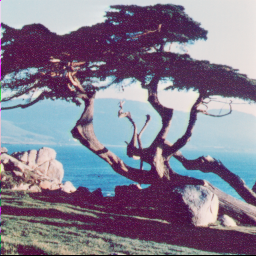

In [775]:
# Read an image
image = Image.open("4.1.06.tiff")

# Show the image
#image.show()

display(image)

In [776]:
# Transform the image to numpy array to manipulate it
image_array = np.array(image)

# Inspect the image array
print(f"Shape: {image_array.shape}")
print(f"Red channel:\n{image_array[:, :, 0]}")
print(f"Green channel:\n{image_array[:, :, 1]}")
print(f"Blue channel:\n{image_array[:, :, 2]}")

Shape: (256, 256, 3)
Red channel:
[[233 202 205 ... 233 235 239]
 [230 203 206 ... 232 234 235]
 [230 200 200 ... 232 233 235]
 ...
 [ 48  81  84 ...  75  68  84]
 [ 64 155 115 ...  81  83  85]
 [  0   0   0 ...   0   0   0]]
Green channel:
[[  0 217 218 ... 229 229 229]
 [217 217 217 ... 227 227 229]
 [217 217 216 ... 228 228 229]
 ...
 [ 43  58  43 ...  40  34  40]
 [ 58 155  99 ...  51  45  55]
 [  0   0   0 ...   0   0   0]]
Blue channel:
[[246 221 220 ... 227 227 226]
 [237 221 220 ... 227 225 228]
 [236 221 220 ... 227 227 226]
 ...
 [ 97  70  76 ...  72  72  81]
 [ 94 135  89 ...  84  74  80]
 [  0   0   0 ...   0   0   0]]


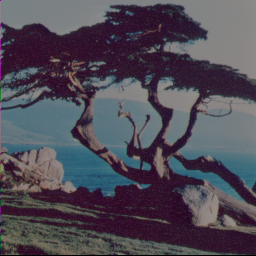

In [777]:
# Manipulation example: make the image darker
image_array_v1 = (image_array * 0.6).astype(np.uint8)
image_v1 = Image.fromarray(image_array_v1)
#image_v1.show()

display(image_v1)

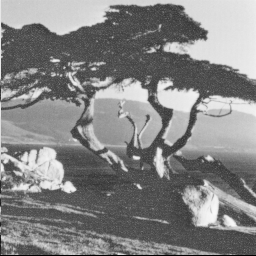

In [778]:
# Manipulation example: manipulate the red channel
image_array_v2 = image_array[:, :, 0]
image_v2 = Image.fromarray(image_array_v2)
#image_v2.show()

display(image_v2)

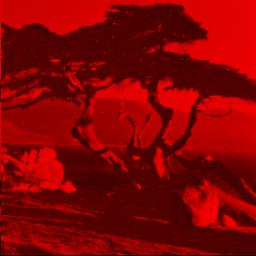

In [779]:
# Why is it grey?
image_array_v2 = image_array.copy()
image_array_v2[:, :, 1] = 0  # Set green channel to 0
image_array_v2[:, :, 2] = 0  # Set blue channel to 0
image_v2 = Image.fromarray(image_array_v2)
#image_v2.show()

display(image_v2)

Shape: (256, 256, 3)
L channel:
[[56.06815251 85.70649804 86.15053474 ... 91.19291207 91.34603556
  91.63142667]
 [88.23904411 85.77686739 85.96353513 ... 90.61551135 90.71930243
  91.37102671]
 [88.21113414 85.56683406 85.28000986 ... 90.86603634 90.94247013
  91.3211776 ]
 ...
 [20.90022822 27.34665366 24.11179235 ... 21.87751504 19.39562593
  23.66076759]
 [26.51742594 63.4755503  43.19728362 ... 26.03168062 24.35542298
  27.4164282 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
a channel:
[[93.62288486 -4.2523033  -3.9780591  ...  0.99443885  1.67341931
   2.86650061]
 [ 8.01890711 -3.92501161 -3.12997968 ...  1.68553016  2.01711271
   1.8468912 ]
 [ 7.83365831 -4.90474217 -4.5822508  ...  1.17023227  1.50912564
   1.50066387]
 ...
 [18.27126423 12.37713207 24.22905097 ... 21.93389944 23.14911905
  27.02166832]
 [11.83917891 -3.61124745  4.6495671  ... 19.85473825 22.23999884
  17.95949597]
 [ 0.          0.          0.         ...  0.          0.
   0.

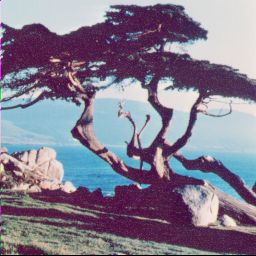

In [780]:
# Transform RGB array to Lab array
from skimage.color import rgb2lab, lab2rgb

image_array_lab = rgb2lab(image_array)
# Inspect the image array
print(f"Shape: {image_array_lab.shape}")
print(f"L channel:\n{image_array_lab[:, :, 0]}")
print(f"a channel:\n{image_array_lab[:, :, 1]}")
print(f"b channel:\n{image_array_lab[:, :, 2]}")

# Transform Lab array to RGB array
image_array_rgb = lab2rgb(image_array_lab)

# Inspect the image array
print(f"Shape: {image_array_rgb.shape}")
print(f"Red channel:\n{image_array_rgb[:, :, 0]}")
print(f"Green channel:\n{image_array_rgb[:, :, 1]}")
print(f"Blue channel:\n{image_array_rgb[:, :, 2]}")

# Show the image
image = Image.fromarray((image_array_rgb * 255).astype(np.uint8))
#image.show()
display(image)

Shape: (256, 256, 3)
H channel:
[[0.82452575 0.53508772 0.52222222 ... 0.05555556 0.04166667 0.03846154]
 [0.775      0.53703704 0.53571429 ... 0.         0.03703704 0.02380952]
 [0.78070175 0.53174603 0.53333333 ... 0.03333333 0.02777778 0.05555556]
 ...
 [0.68209877 0.91304348 0.86585366 ... 0.84761905 0.81578947 0.84469697]
 [0.69444444 0.16666667 0.06410256 ... 0.81818182 0.87280702 0.86111111]
 [0.         0.         0.         ... 0.         0.         0.        ]]
S channel:
[[1.         0.08597285 0.06818182 ... 0.02575107 0.03404255 0.05439331]
 [0.08438819 0.08144796 0.06363636 ... 0.02155172 0.03846154 0.02978723]
 [0.08050847 0.09502262 0.09090909 ... 0.02155172 0.02575107 0.03829787]
 ...
 [0.55670103 0.28395062 0.48809524 ... 0.46666667 0.52777778 0.52380952]
 [0.38297872 0.12903226 0.22608696 ... 0.39285714 0.45783133 0.35294118]
 [0.         0.         0.         ... 0.         0.         0.        ]]
V channel:
[[0.96470588 0.86666667 0.8627451  ... 0.91372549 0.921568

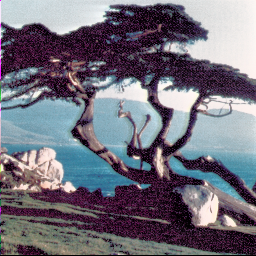

In [781]:
# Transform RGB to HSV
from skimage.color import rgb2hsv, hsv2rgb

image_array_hsv = rgb2hsv(image_array)
# Inspect the image array
print(f"Shape: {image_array_hsv.shape}")
print(f"H channel:\n{image_array_hsv[:, :, 0]}")
print(f"S channel:\n{image_array_hsv[:, :, 1]}")
print(f"V channel:\n{image_array_hsv[:, :, 2]}")

# Histogram equalization on the V channel
from skimage.exposure import equalize_hist

image_array_hsv[:, :, 2] = equalize_hist(image_array_hsv[:, :, 2])
print(f"V channel after equalization:\n{image_array_hsv[:, :, 2]}")

# Transform HSV to RGB
image_array_rgb = hsv2rgb(image_array_hsv)

# Show the image
image = Image.fromarray((image_array_rgb * 255).astype(np.uint8))
#image.show()
display(image)

# Part 1

## Utils

In [782]:
import os
from matplotlib import pyplot as plt
import ipyplot
import pandas as pd

In [783]:
def image_to_array(image : Image) -> np.array:
    return np.array(image, dtype=float)

def array_to_image(arr : np.ndarray) -> Image:
    return Image.fromarray(arr.astype(np.uint8))

def concat_horizontal(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


In [784]:
sample_image = Image.open('dataset/1/4.1.01.tiff')
sample_array = image_to_array(sample_image)

## Metric Calculation Functions

### Compute Power

In [785]:
def compute_power(image_array):
    # Constants
    gamma = 0.7755
    w_0 = 1.48169521e-6
    w_R = 2.13636845e-7
    w_G = 1.77746706e-7
    w_B = 2.14348309e-7

    # Normalize pixel values to rang[0,1]
    image_array = image_array/255.0

    # Extract R,G,B channels
    R = image_array[:,:,0]
    G = image_array[:,:,1]
    B = image_array[:,:,2]

    # Compute pixel-wise power consumption
    P_pixel = w_R*(R**gamma) + w_G * (G ** gamma) + w_B * (B ** gamma)

    P_image = w_0 + np.sum(P_pixel)

    return P_image
#########################################
# Load the image
image_path = "4.1.06.tiff"  
image = Image.open(image_path)
image_array = np.array(image)

# Compute power consumption
power_consumption = compute_power(image_array)

# Display the result
print(f"Power consumption for the image: {power_consumption:.10f}")

Power consumption for the image: 0.0235280153


In [786]:
def compute_power_saved(original, distorted):
    o = compute_power(original)
    d = compute_power(distorted)

    return (o-d)/o

#############################################
# Compute distortion between original and darker image
distortion_darker = compute_power_saved(image_array, image_array_v1)
print(f"Distortion (original vs. darker): {distortion_darker*100:.2f}%")

# Compute distortion between original and red-only image
distortion_red_only = compute_power_saved(image_array, image_array_v2)
print(f"Distortion (original vs. red-only): {distortion_red_only*100:.2f}%")

Distortion (original vs. darker): 32.98%
Distortion (original vs. red-only): 64.83%


### Compute Distortion

In [787]:
def compute_distortion(original_image, transformed_image):
    # Convert both images to L*a*b* space
    lab_original = rgb2lab(original_image)
    lab_transformed = rgb2lab(transformed_image)
    
    # Compute the Euclidean distance for each pixel
    pixel_distances = np.sqrt(
        (lab_original[:, :, 0] - lab_transformed[:, :, 0]) ** 2 +
        (lab_original[:, :, 1] - lab_transformed[:, :, 1]) ** 2 +
        (lab_original[:, :, 2] - lab_transformed[:, :, 2]) ** 2
    )
    
    # Sum all pixel distances to calculate total distortion
    epsilon = np.sum(pixel_distances)
    
    return epsilon

#############################################
# Compute distortion between original and darker image
distortion_darker = compute_distortion(image_array, image_array_v1)
print(f"Distortion (original vs. darker): {distortion_darker:.2f}")

# Compute distortion between original and red-only image
distortion_red_only = compute_distortion(image_array, image_array_v2)
print(f"Distortion (original vs. red-only): {distortion_red_only:.2f}")

Distortion (original vs. darker): 1493273.27
Distortion (original vs. red-only): 4534181.70


In [788]:
# Function to compute percentage distortion
def compute_percentage_distortion(image, distorted):
    
    distortion = compute_distortion(image/255, distorted/255)
    
    # Extract image dimensions
    height, width, _ = image.shape
    
    # Maximum possible Euclidean distance in Lab space
    L_max = 100.0
    a_max = 255.0
    b_max = 255.0
    max_distance_per_pixel = np.sqrt(L_max**2 + a_max**2 + b_max**2)
    
    # Total maximum possible distortion
    max_possible_distortion = max_distance_per_pixel * height * width
    
    # Calculate percentage distortion
    percentage_distortion = (distortion / max_possible_distortion)
    
    return percentage_distortion


# Compute distortion between original and darker image
distortion_darker = compute_percentage_distortion(image_array, image_array_v1)
print(f"Distortion (original vs. darker): {distortion_darker*100:.2f} %")

# Compute distortion between original and red-only image
distortion_red_only = compute_percentage_distortion(image_array, image_array_v2)
print(f"Distortion (original vs. red-only): {distortion_red_only*100:.2f} %")


Distortion (original vs. darker): 6.09 %
Distortion (original vs. red-only): 18.49 %


# Data Manipulation

In [789]:
dataset_data = [
    ('1', 'dataset/1/'),
    ('2', 'dataset/2/')
]

dataset = []
for name, dataset_path in dataset_data:
    dataset += [(name, image_to_array(Image.open(dataset_path + path))) for path in os.listdir(dataset_path)]

df = pd.DataFrame(columns=['dataset', 'image'], data=dataset)
df1 = df[df['dataset'] == '1']
df2 = df[df['dataset'] == '2']
df3 = df[df['dataset'] == '3']

In [790]:
def get_metrics(dataset, function, parameters):
    powers = []
    distortions = []

    for image in dataset:
        distorted_image = function(image, parameters) if not parameters is None else function(image)

        power_saved = compute_power_saved(image, distorted_image)
        powers.append(power_saved)

        distortion = compute_percentage_distortion(image, distorted_image)
        distortions.append(distortion)

    return sum(powers)/len(powers), max(powers), min(powers), sum(distortions)/len(distortions), max(distortions), min(distortions)

## Transformations

In [791]:
transformations = {}

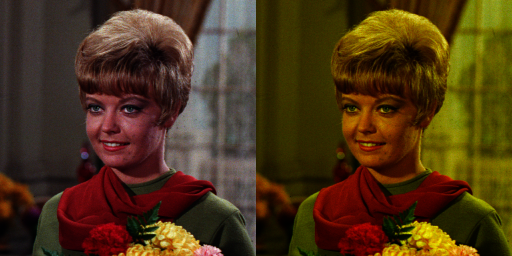

In [792]:
def hungry_blue(arr_in : np.ndarray, reduction : float) -> np.ndarray:
    arr = arr_in.copy()
    arr[:,:,2] = np.clip(arr[:,:,2] - 255*reduction, a_min = 0, a_max = np.inf)
    
    return arr

transformations['hungry_blue'] = (hungry_blue, [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

hungry_blue_array = hungry_blue(sample_array, .5)
concat_horizontal(sample_image, array_to_image(hungry_blue_array))

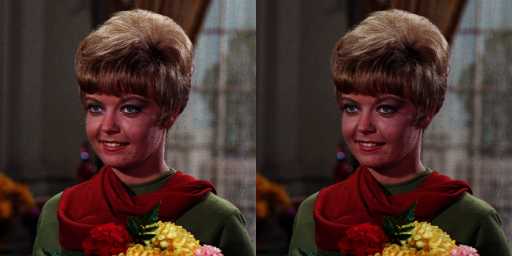

In [793]:
def dimming(arr_in : np.ndarray, reduction : float) -> np.ndarray:
    arr = arr_in.copy()
    arr = arr*reduction
    
    return arr

transformations['dimming'] = (dimming, [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

dimmed_array = dimming(sample_array, .9)
concat_horizontal(sample_image, array_to_image(dimmed_array))

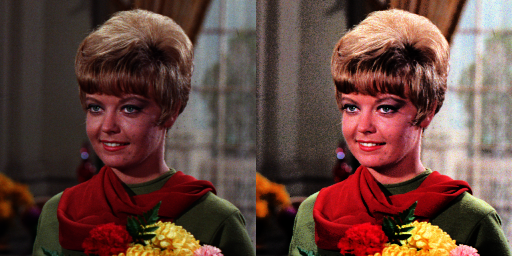

In [794]:
def hist_eq(arr_in : np.ndarray):
    image_array_hsv = rgb2hsv(arr_in/255)
    image_array_hsv[:, :, 2] = equalize_hist(image_array_hsv[:, :, 2])

    return hsv2rgb(image_array_hsv)*255

transformations['hist_equalization'] = (hist_eq, None)

eq_array = hist_eq(sample_array)
concat_horizontal(sample_image, array_to_image(eq_array))

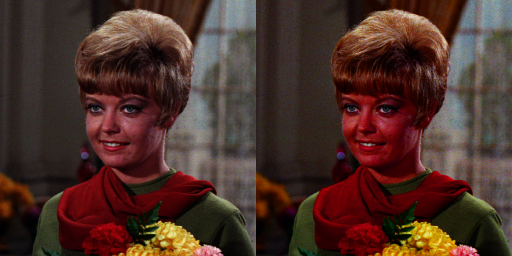

In [795]:
def dimm_saturation(arr_in : np.ndarray, increase):
    image_array_hsv = rgb2hsv(arr_in/255)
    image_array_hsv[:, :, 1] = np.clip(image_array_hsv[:, :, 1] * increase, a_min=0, a_max = 1)

    return hsv2rgb(image_array_hsv)*255

transformations['dimm_saturation'] = (dimm_saturation, [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2])

dimm_saturation_array = dimm_saturation(sample_array, 1.5)
concat_horizontal(sample_image, array_to_image(dimm_saturation_array))

In [796]:
sdf = [sample_array]
stats = []

for name in transformations.keys():
    function, parameters = transformations[name]

    if not parameters is None:
        for parameter in parameters:
            stats.append([name, str(parameter), *get_metrics(sdf, function, parameter)])
    else:
        stats.append([name, str(parameter), *get_metrics(sdf, function, None)])

print(len(sdf), 'images analyzed ')

1 images analyzed 


In [797]:
df_stats = pd.DataFrame(columns = ['type', 'reduction', 'p_avg', 'p_min', 'p_max', 'd_avg', 'd_min', 'd_max'], data=stats)
df_stats.sample(5)

,type,reduction,p_avg,p_min,p_max,d_avg,d_min,d_max
25,dimm_saturation,1.2,0.046810,0.046810,0.046810,0.006498,0.006498,0.006498
6,hungry_blue,0.6,0.290818,0.290818,0.290818,0.059885,0.059885,0.059885
4,hungry_blue,0.4,0.270725,0.270725,0.270725,0.058031,0.058031,0.058031
2,hungry_blue,0.2,0.202752,0.202752,0.202752,0.046599,0.046599,0.046599
28,dimm_saturation,1.5,0.098403,0.098403,0.098403,0.013968,0.013968,0.013968


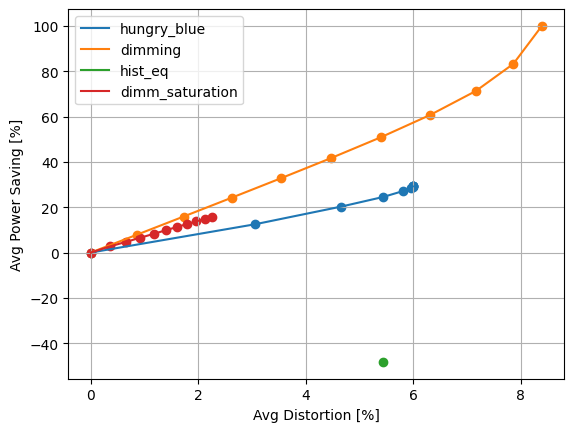

In [798]:
for tp in df_stats['type'].unique():
    df_stats_type = df_stats[df_stats['type'] == tp]

    plt.plot(df_stats_type['d_avg']*100, df_stats_type['p_avg']*100, label=tp)
    plt.scatter(df_stats_type['d_avg']*100, df_stats_type['p_avg']*100)

plt.legend()
plt.xlabel('Avg Distortion [%]')
plt.ylabel('Avg Power Saving [%]')
#plt.gca().invert_xaxis()
plt.grid()

# Part 2

## DVS

In [799]:
def compute_pixel_current():
    raise NotImplementedError

In [800]:
def compute_panel_power():
    raise NotImplementedError

In [801]:
from typing import Tuple

def displayed_image(
        i_cell: np.ndarray,
        vdd: float,
        p1: float = 4.251e-5,
        p2: float = -3.029e-4,
        p3: float = 3.024e-5,
        orig_vdd: float = 15,
        ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Display an image on the OLED display taking into account the effect of DVS.

    :param i_cell: An array of the currents drawn by each pixel of the display.
    :param vdd: The new voltage of the display.
    """
    i_cell_max = (p1 * vdd * 1) + (p2 * 1) + p3
    image_rgb_max = (i_cell_max - p3) / (p1 * orig_vdd + p2) * 255
    out = np.round((i_cell - p3) / (p1 * orig_vdd + p2) * 255)
    original_image = out.copy()

    # Clip the values exceeding `i_cell_max` to `image_rgb_max`
    out[i_cell > i_cell_max] = image_rgb_max

    return original_image.astype(np.uint8), out.astype(np.uint8)

Shape: (176, 220, 3)
Red channel:
[[2.46842941e-04 2.24526275e-04 2.03522353e-04 ... 9.45645098e-05
  9.45645098e-05 9.45645098e-05]
 [2.46842941e-04 2.24526275e-04 2.03522353e-04 ... 9.45645098e-05
  9.45645098e-05 9.45645098e-05]
 [2.46842941e-04 2.24526275e-04 2.03522353e-04 ... 9.45645098e-05
  9.45645098e-05 9.45645098e-05]
 ...
 [2.88850784e-04 2.78348824e-04 2.67846863e-04 ... 3.32171373e-04
  3.21669412e-04 3.21669412e-04]
 [2.88850784e-04 2.78348824e-04 2.67846863e-04 ... 3.32171373e-04
  3.32171373e-04 3.21669412e-04]
 [2.88850784e-04 2.78348824e-04 2.67846863e-04 ... 3.32171373e-04
  3.32171373e-04 3.11167451e-04]]
Green channel:
[[1.41823333e-04 1.20819412e-04 1.10317451e-04 ... 7.22478431e-05
  6.69968627e-05 6.69968627e-05]
 [1.36572353e-04 1.26070392e-04 1.10317451e-04 ... 7.22478431e-05
  6.69968627e-05 6.69968627e-05]
 [1.31321373e-04 1.20819412e-04 1.10317451e-04 ... 7.22478431e-05
  6.69968627e-05 6.69968627e-05]
 ...
 [1.73329216e-04 1.62827255e-04 1.57576275e-04 ..

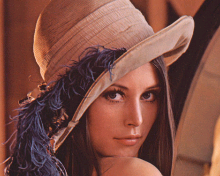

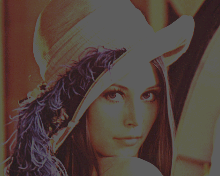

In [802]:
from scipy.io import loadmat

# Load the .mat file
mat_data = loadmat('sample_cell_current.mat')["I_cell_sample"]

# Inspect the loaded data
print(f"Shape: {mat_data.shape}")
print(f"Red channel:\n{mat_data[:, :, 0]}")
print(f"Green channel:\n{mat_data[:, :, 1]}")
print(f"Blue channel:\n{mat_data[:, :, 2]}")

image_array_orig, image_array_w_dvs = displayed_image(mat_data, 10)
image_orig = Image.fromarray(image_array_orig)
#image_orig.show()
display(image_orig)
image_w_dvs = Image.fromarray(image_array_w_dvs)
#image_w_dvs.show()
display(image_w_dvs)
